In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-10-2020.csv')

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-11 02:32:30,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-11 02:32:30,30.295065,-92.414197,148,11,0,137,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-11 02:32:30,37.767072,-75.632346,508,7,0,501,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-11 02:32:30,43.452658,-116.241552,733,19,0,714,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-11 02:32:30,41.330756,-94.471059,3,0,0,3,"Adair, Iowa, US"


In [4]:
latest_data['Country_Region'] == "Singapore"

0       False
1       False
2       False
3       False
4       False
        ...  
3229    False
3230    False
3231    False
3232    False
3233    False
Name: Country_Region, Length: 3234, dtype: bool

In [5]:
latest_data[latest_data['Country_Region'] == "Singapore"]

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
3199,NaN,NaN,NaN,Singapore,2020-05-11 02:32:30,1.2833,103.8333,23336,20,2721,20595,Singapore


In [6]:
latest_data.iloc[3199]

FIPS                              NaN
Admin2                            NaN
Province_State                    NaN
Country_Region              Singapore
Last_Update       2020-05-11 02:32:30
Lat                            1.2833
Long_                         103.833
Confirmed                       23336
Deaths                             20
Recovered                        2721
Active                          20595
Combined_Key                Singapore
Name: 3199, dtype: object

In [7]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,782,789,795,803,820,832,842,850,856,868
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,745,747,748,750,751,751,752,752,754,755
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,30,35,35,35,36,36,36,43,43,45


In [8]:
confirmed_df.keys()

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20', '5/7/20',
       '5/8/20', '5/9/20', '5/10/20'],
      dtype='object', length=114)

In [9]:
cols = confirmed_df.keys()

Get all the dates for the outbreak

In [10]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [11]:
dates = confirmed.keys()

In [12]:
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20', '5/7/20',
       '5/8/20', '5/9/20', '5/10/20'],
      dtype='object', length=110)

In [13]:
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 
malaysia_cases = [] 
singapore_cases = [] 
india_cases = [] 

china_deaths = [] 
italy_deaths = []
us_deaths = [] 
spain_deaths = [] 
france_deaths = [] 
malaysia_deaths = [] 
singapore_deaths = [] 
india_deaths = []

china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
spain_recoveries = [] 
france_recoveries = [] 
malaysia_recoveries = [] 
singapore_recoveries = [] 
india_recoveries = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    
    # confirmed cases
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    malaysia_cases.append(confirmed_df[confirmed_df['Country/Region']=='Malaysia'][i].sum())
    singapore_cases.append(confirmed_df[confirmed_df['Country/Region']=='Singapore'][i].sum())
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    
    # deaths
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][i].sum())
    malaysia_deaths.append(deaths_df[deaths_df['Country/Region']=='Malaysia'][i].sum())
    singapore_deaths.append(deaths_df[deaths_df['Country/Region']=='Singapore'][i].sum())
    india_deaths.append(deaths_df[deaths_df['Country/Region']=='India'][i].sum())
    
    # recoveries
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    france_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='France'][i].sum())
    malaysia_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Malaysia'][i].sum())
    singapore_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Singapore'][i].sum())
    india_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='India'][i].sum())

Get daily increase in confirmed cases, deaths and recoveries

In [14]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d

# confirmed cases
world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
malaysia_daily_increase = daily_increase(malaysia_cases)
singapore_daily_increase = daily_increase(singapore_cases)
india_daily_increase = daily_increase(india_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
spain_daily_death = daily_increase(spain_deaths)
france_daily_death = daily_increase(france_deaths)
malaysia_daily_death = daily_increase(malaysia_deaths)
singapore_daily_death = daily_increase(singapore_deaths)
india_daily_death = daily_increase(india_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
spain_daily_recovery = daily_increase(spain_recoveries)
france_daily_recovery = daily_increase(france_recoveries)
malaysia_daily_recovery = daily_increase(malaysia_recoveries)
singapore_daily_recovery = daily_increase(singapore_recoveries)
india_daily_recovery = daily_increase(india_recoveries)

In [15]:
# Convert list to numpy array. Reshape from 1D Array to 2D Array with 1 column
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [16]:
# Dates till date of 'latest_data' dataset 
Current_dates = np.array([i for i in range(len(dates))]).reshape(-1, 1)
# Future forcasting                          
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [17]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
Current_dates_datetime = []
for i in range(len(Current_dates)):
    Current_dates_datetime.append((start_date + datetime.timedelta(days=i)).strftime('%d %b'))

In [18]:
# Reshape array with 1 row
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
Current_dates_datetime = np.array([i for i in Current_dates_datetime]).reshape(1, -1)[0]

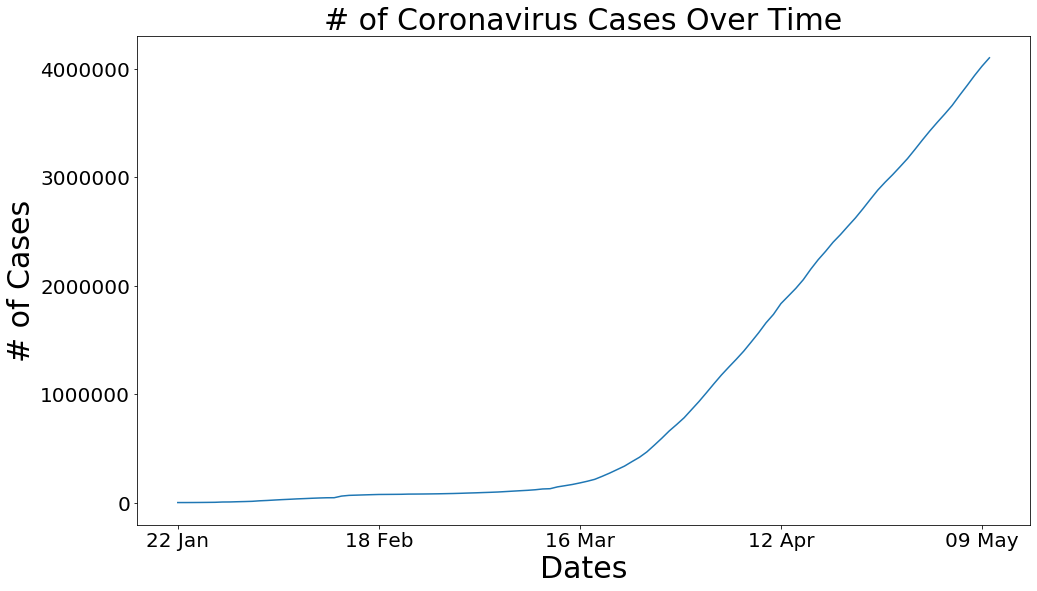

In [19]:
plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()

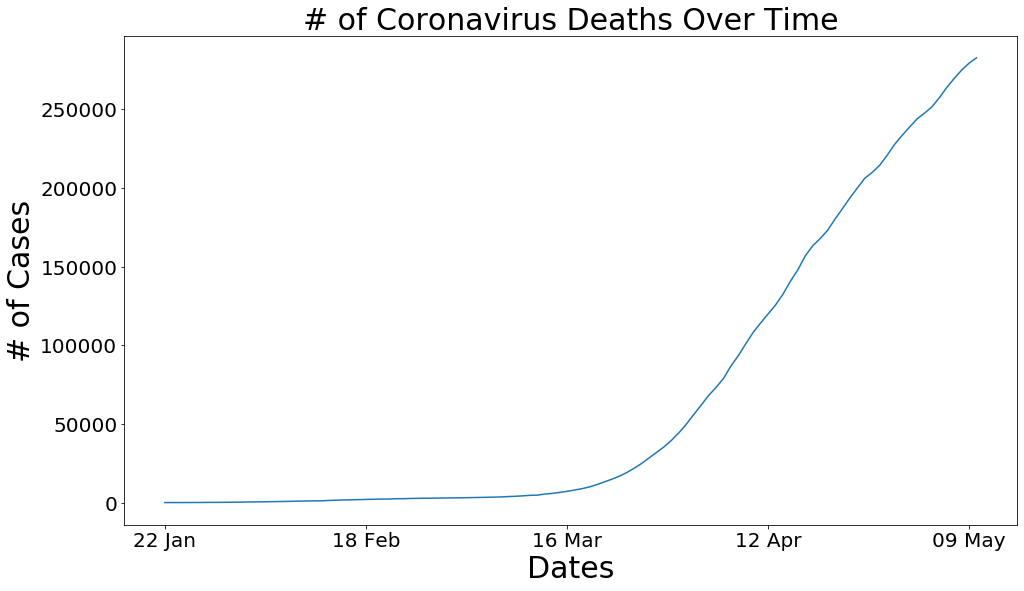

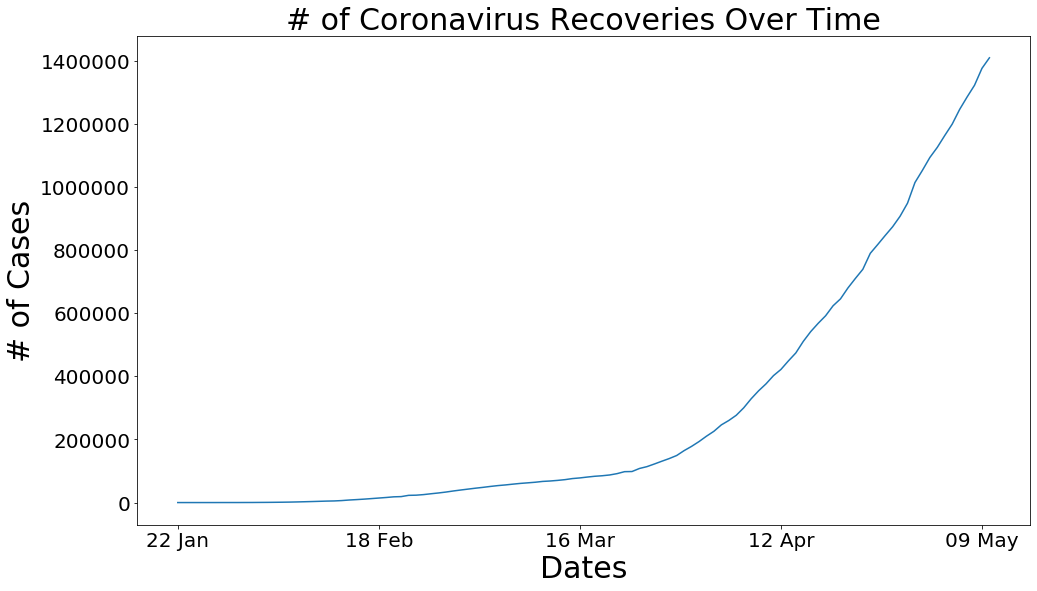

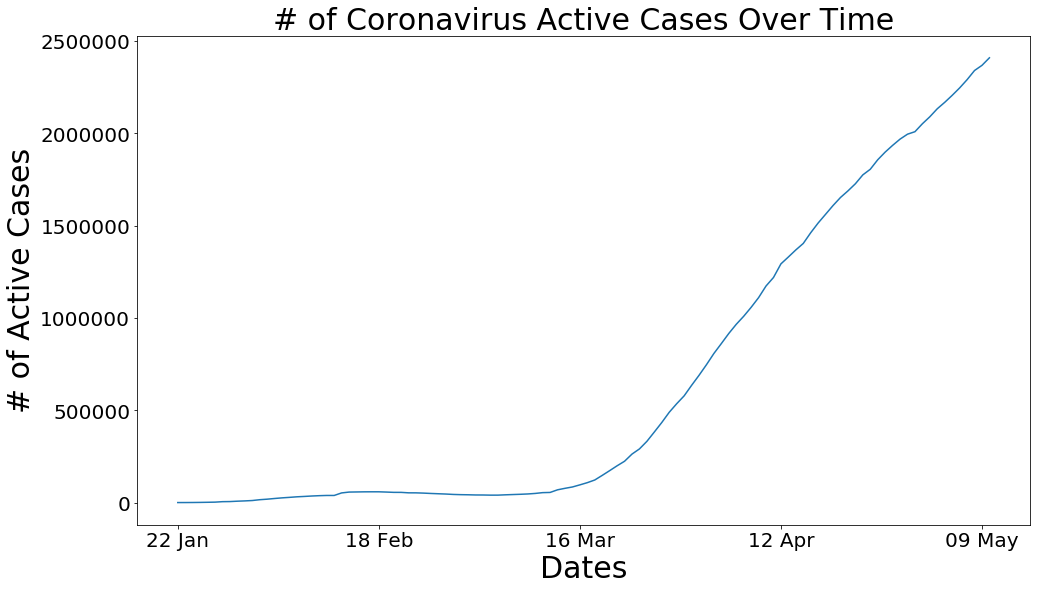

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()

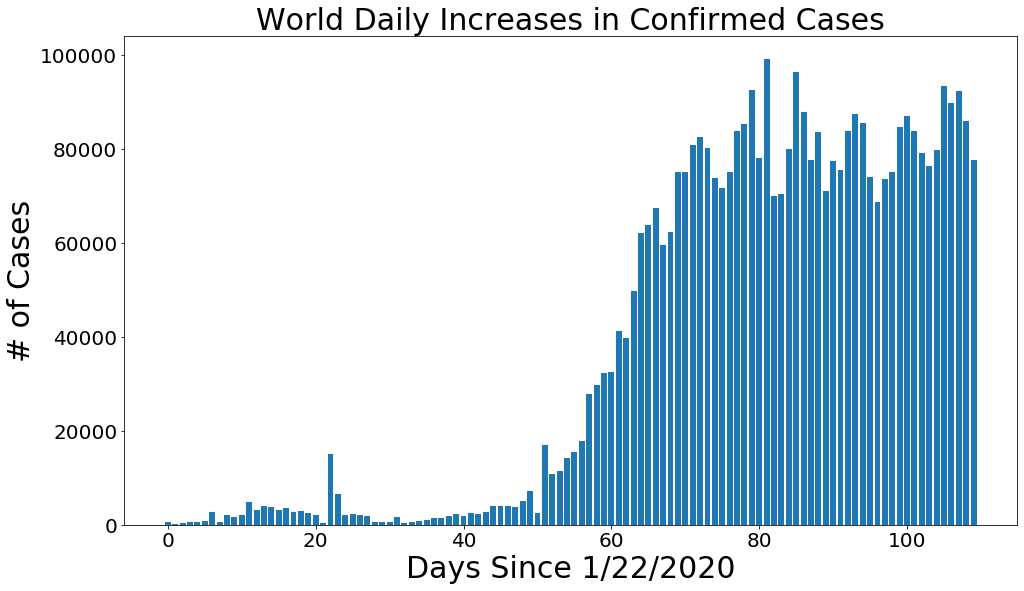

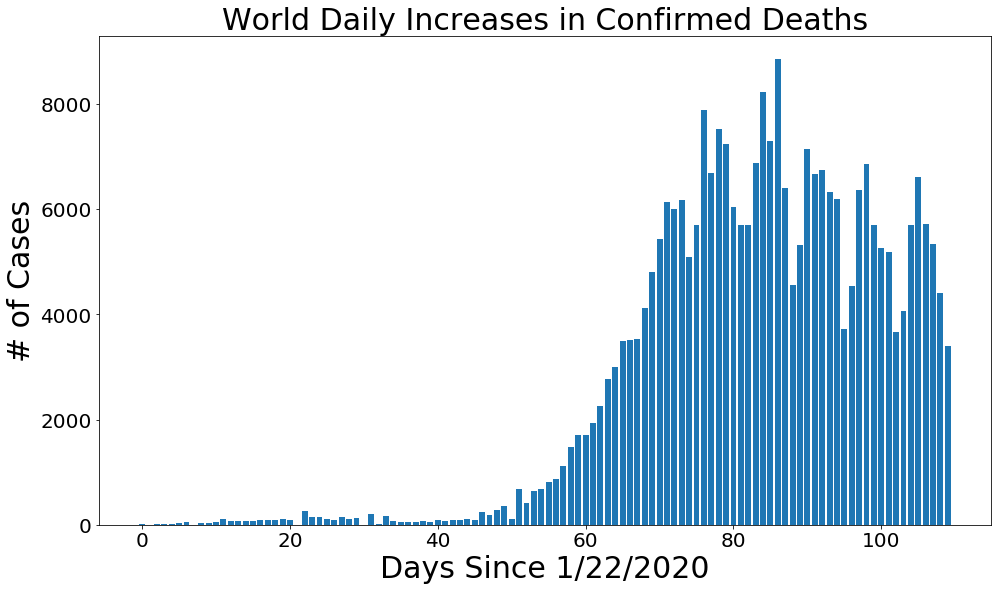

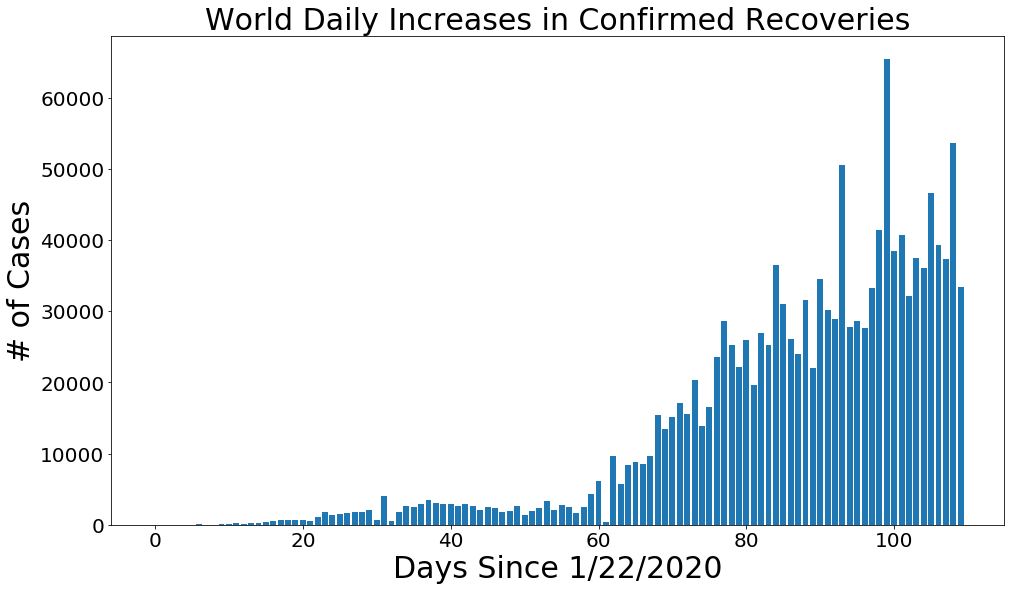

In [21]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [43]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/12))),size=15)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y2)
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/12))),size=15)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/12))),size=15)
    plt.yticks(size=20)
    plt.show()

    plt.figure(figsize=(16, 9))
    plt.bar(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=20)
    plt.xlabel('Dates', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/12))),size=15)
    plt.yticks(size=20)
    plt.show()

Singapore Visualization

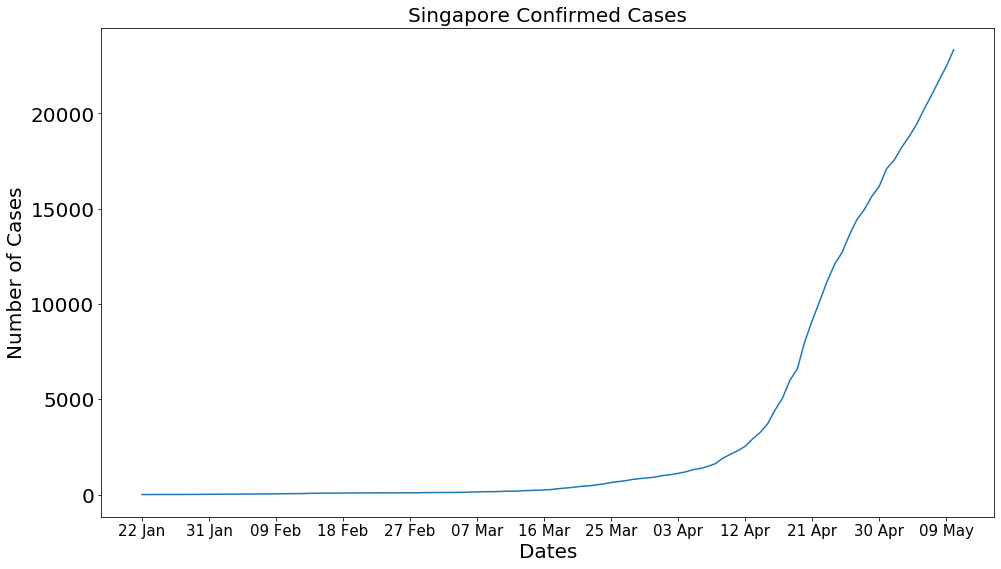

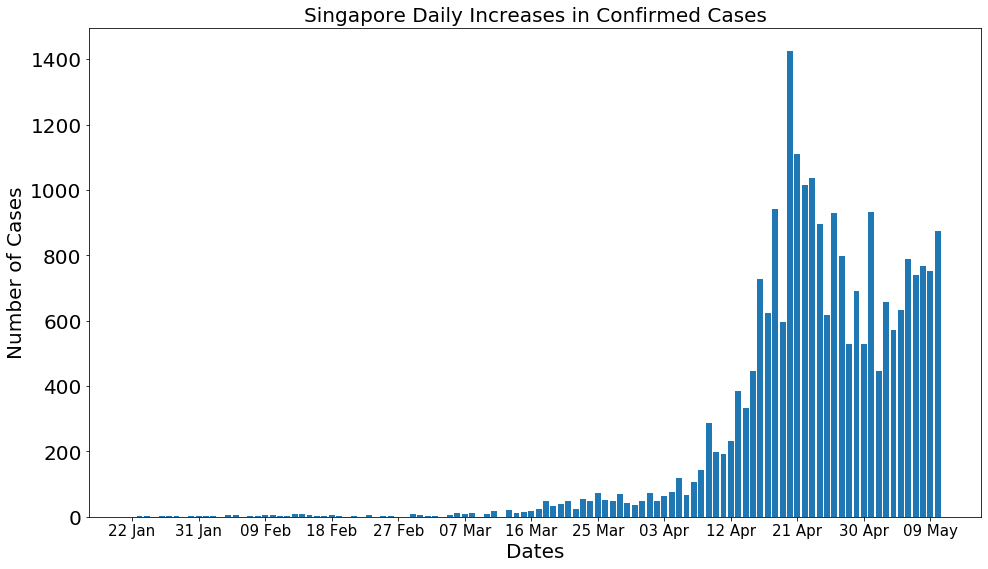

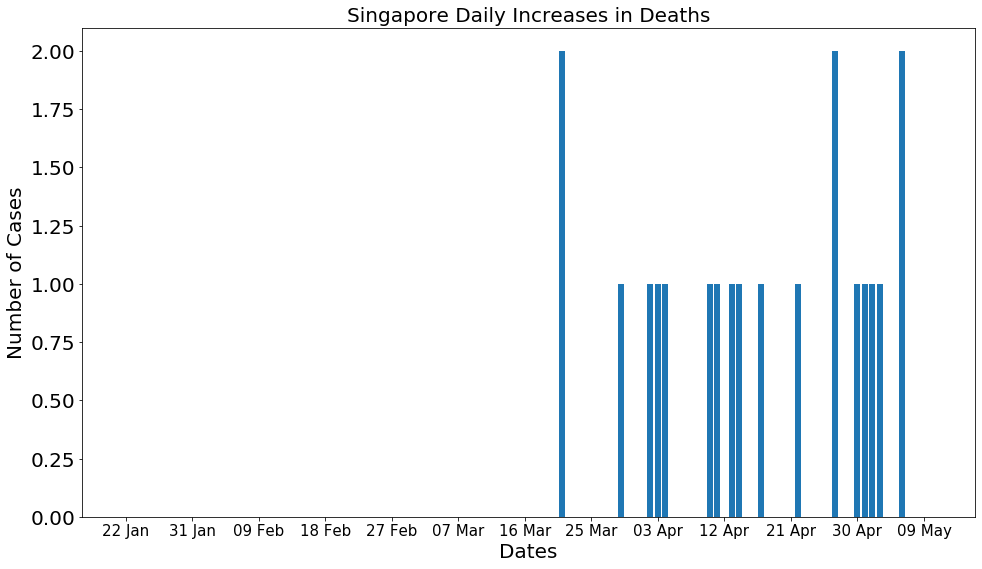

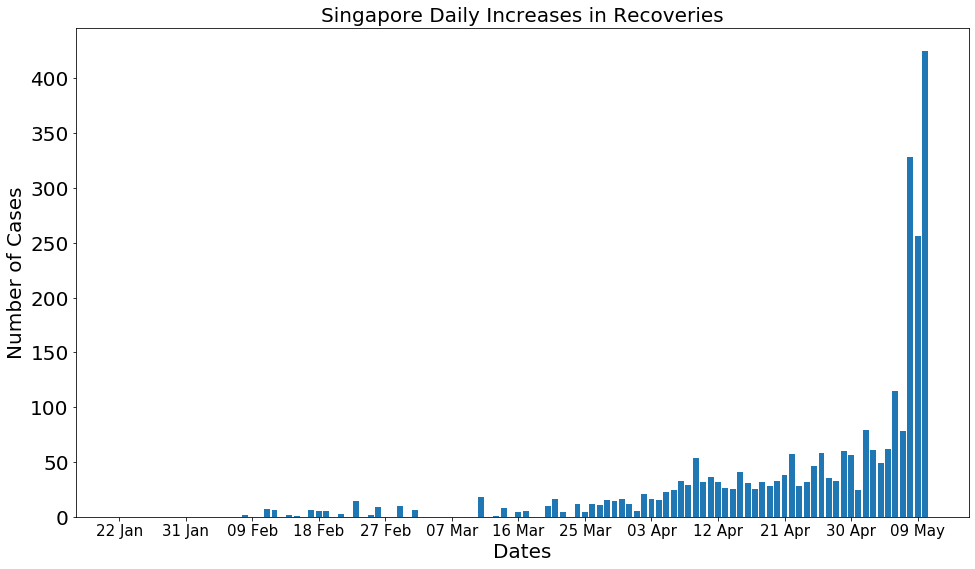

In [44]:
country_plot(Current_dates_datetime, singapore_cases, singapore_daily_increase, singapore_daily_death, singapore_daily_recovery, 'Singapore')

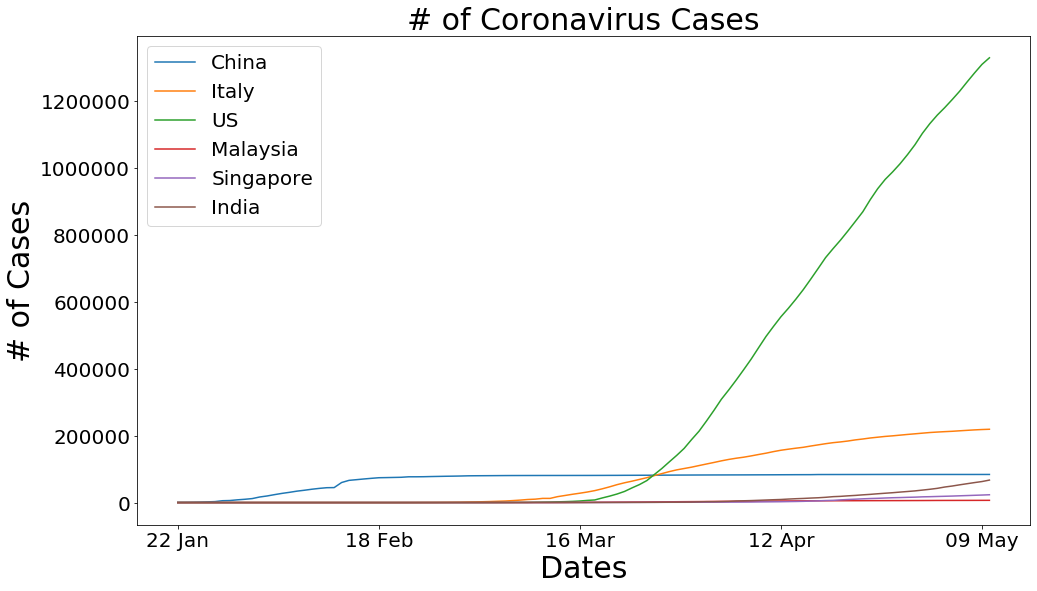

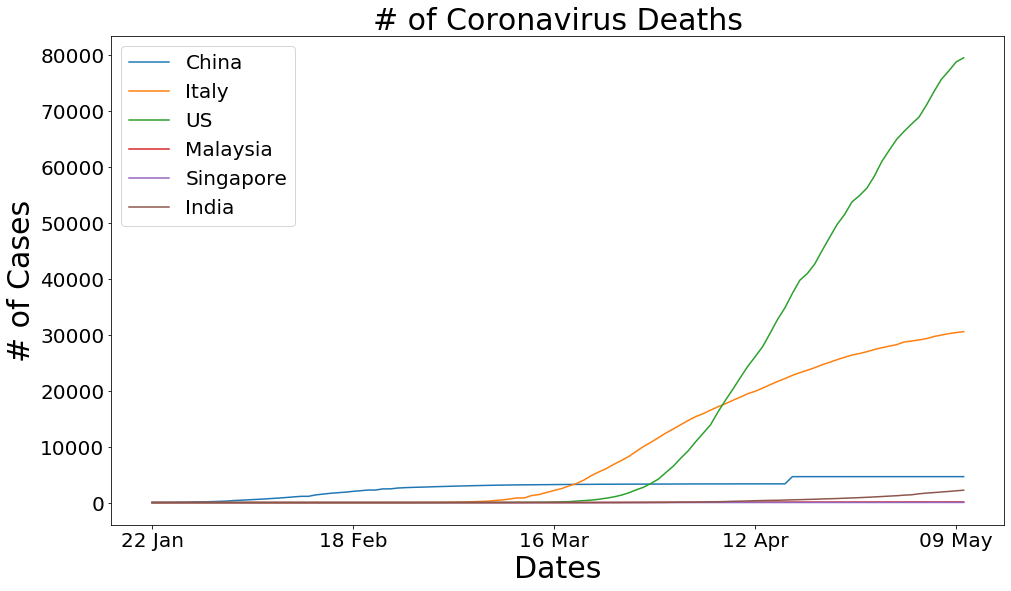

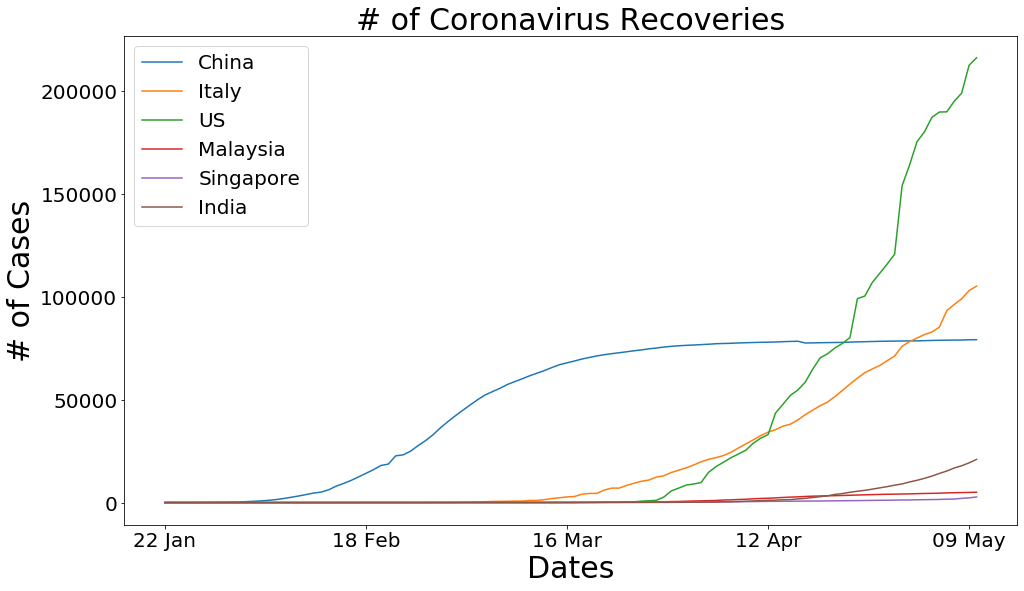

In [24]:
plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, china_cases)
plt.plot(Current_dates_datetime, italy_cases)
plt.plot(Current_dates_datetime, us_cases)
plt.plot(Current_dates_datetime, malaysia_cases)
plt.plot(Current_dates_datetime, singapore_cases)
plt.plot(Current_dates_datetime, india_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Malaysia', 'Singapore', 'India'], prop={'size': 20})
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, china_deaths)
plt.plot(Current_dates_datetime, italy_deaths)
plt.plot(Current_dates_datetime, us_deaths)
plt.plot(Current_dates_datetime, malaysia_deaths)
plt.plot(Current_dates_datetime, singapore_deaths)
plt.plot(Current_dates_datetime, india_deaths)

plt.title('# of Coronavirus Deaths', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Malaysia', 'Singapore', 'India'], prop={'size': 20})
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(Current_dates_datetime, china_recoveries)
plt.plot(Current_dates_datetime, italy_recoveries)
plt.plot(Current_dates_datetime, us_recoveries)
plt.plot(Current_dates_datetime, malaysia_recoveries)
plt.plot(Current_dates_datetime, singapore_recoveries)
plt.plot(Current_dates_datetime, india_recoveries)
plt.title('# of Coronavirus Recoveries', size=30)
plt.xlabel('Dates', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Malaysia', 'Singapore', 'India'], prop={'size': 20})
plt.xticks(list(np.arange(0,len(Current_dates_datetime),int(len(Current_dates_datetime)/4))),size=20)
plt.yticks(size=20)
plt.show()